# Fermi-Hubbard Model

Some of the simplest (while still interesting) problems involve 1D spin chains or a Hubbard model, either with fermions or bosons. A [Hubbard model](https://en.wikipedia.org/wiki/Hubbard_model) For fermions, the Pauli's exclusion principle ensures that no two of them can have the exact same quantum numbers.

## Encoding the states with qubits

In order to proceed with simulating the system, we need to choose a suitable encoding scheme to represent the state of the system using the available qubits. For a single lattice site, the maximum number of fermions that can occupy it is 2, and this implies that there are a total of 4 possible states at any site (a state with no fermions, a state with an up spin, a state with a down spin, and a state with both up and down spins). This encoding would require 2 qubits per lattice site, which restricts the size of the lattice that can be simulated. A simpler encoding scheme can be implemented by treating the spin-up and spin-down fermions as if they are separate from each other, with the former occupying one L-site lattice, and the latter occupying a copy of the same lattice. In this case, each site can accomodate up to one fermion, which can be represented using a single qubit. Consequently, the Hamiltonian can be expressed as a sum over 2L sites, with the hopping of the spin-up fermions confined to the first L sites, and the hopping for the spin-down particles confined to the remaining L sites.
$$
H = \sum_{j=1}^{L-1} \frac{J}{2}(X_{j}X_{j+1} + Y_{j}Y_{j+1} + X_{j+L}X_{j+1+L} + Y_{j+L}Y_{j+1+L}) + \sum_{j=1}^{L} \frac{U}{4}(1- Z_{j} - Z_{j+L} + Z_{j}Z_{j+L})
$$

In [3]:
from qiskit import QuantumCircuit
from qiskit.extensions import Initialize
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit import Aer

backend = Aer.get_backend("aer_simulator")

In [39]:
import numpy as np


class Circuit:
    """Return a circuit for Nq qubits.

    Attributes:
    ----------

    psi : numpy.array
        Initial state vector (default provided).
    Nq : int
        Number of qubits.
    iter_t: int
        Number of iterations (min=1).
    min_inc : float
        Rotation angle, calulated by default.
    """

    def __init__(
        self, psi=None, Nq=3, iter_t=1, min_inc=np.pi * 10 ** (-1), U=0.5, J=1.0
    ):
        self.Nq = Nq
        if psi is None:
            # Set the initial state to be a particle halfway on the lattice
            # This is represented by the bit string with the half-most significant bit set
            psi = np.zeros(2**Nq)
            psi[2 ** (Nq // 2)] = 1
        psi = psi / np.linalg.norm(psi)
        self.psi = psi

        self.t = iter_t - 1

        self.min_inc = min_inc
        self.U = U
        self.J = J

    def initialize(self):
        qc = QuantumCircuit(self.Nq, self.Nq)

        init_gate = Initialize(self.psi)
        init_gate.label = r"$\psi$"
        qc.append(init_gate, qc.qubits)

        qc.save_statevector(label="psi_i")

        return qc

    def get_circuit(self, qc=None):
        """Return circuit for single time step evolution."""

        if qc is None:
            qc = self.initialize()

        theta = -self.min_inc

        alpha = theta * self.J
        beta = theta * self.U

        for i in range(self.Nq):
            qc.rx(alpha, i)
            qc.ry(2 * alpha, i)
            qc.rx(alpha, i)
            qc.rz(2 * beta, i)
            qc.rx(alpha, i)
            qc.ry(2 * alpha, i)
            qc.rx(alpha, i)

        for i in range(1, self.Nq // 2 - 1):
            qc.rx(alpha, i)
            qc.ry(2 * alpha, i)
            qc.rx(alpha, i)
            qc.rz(2 * beta, i)
            qc.rx(alpha, i)
            qc.ry(2 * alpha, i)
            qc.rx(alpha, i)

        for i in range(self.Nq // 2 + 1, self.Nq - 1):
            qc.rx(alpha, i)
            qc.ry(2 * alpha, i)
            qc.rx(alpha, i)
            qc.rz(2 * beta, i)
            qc.rx(alpha, i)
            qc.ry(2 * alpha, i)
            qc.rx(alpha, i)

        return qc

    def get_circuit_steps(self):
        """Return circuit for t time steps."""

        qc = self.get_circuit()

        for i in range(self.t):
            self.get_circuit(qc)

        qc.barrier()

        for i in range(self.Nq):
            qc.measure(i, i)

        return qc

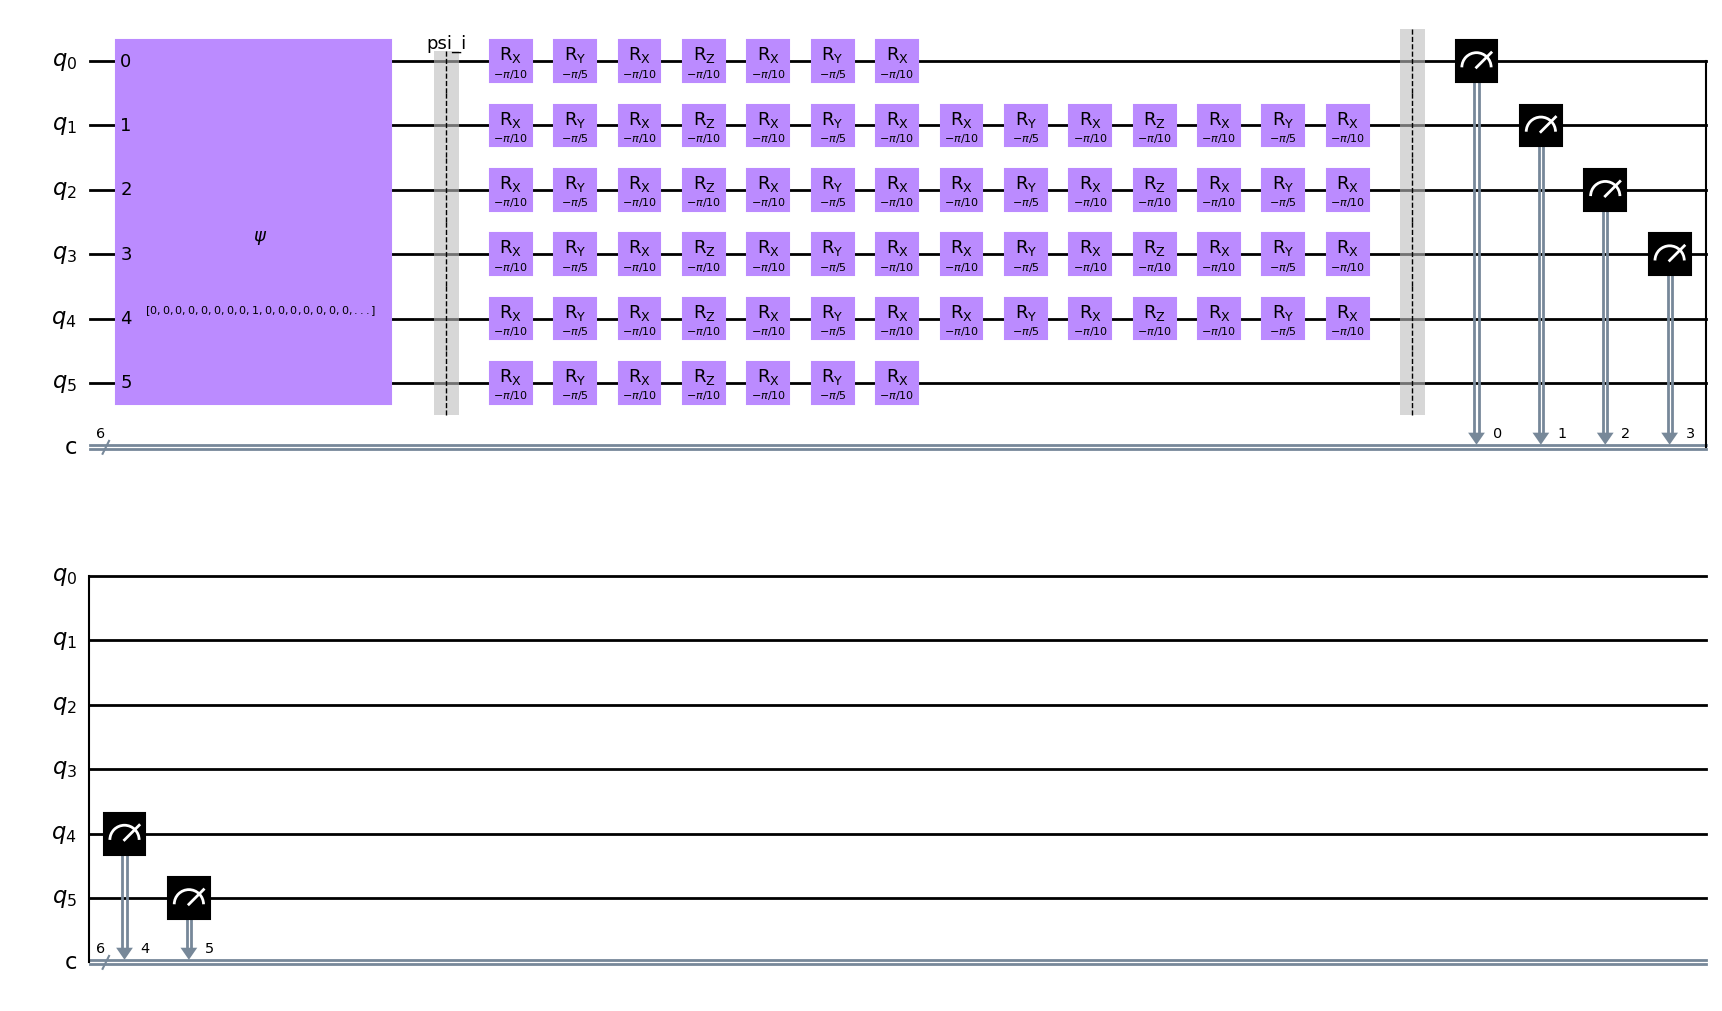

In [40]:
obj = Circuit(Nq=6, iter_t=1)
qc = obj.get_circuit_steps()
qc.draw("mpl")

Job Status: job has successfully run


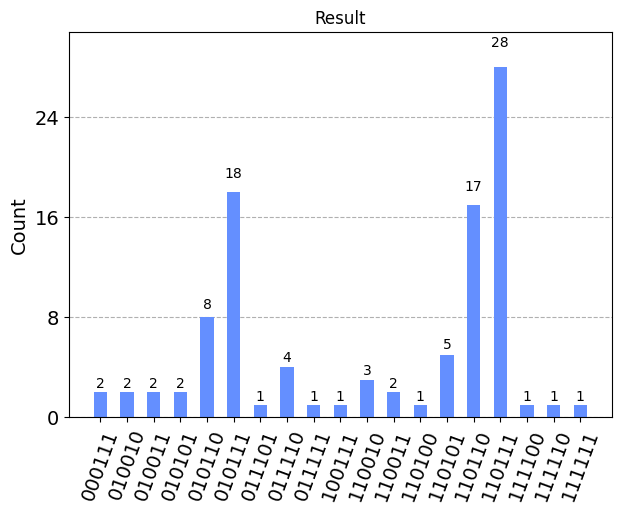

In [41]:
circuit = qc
job = backend.run(circuit, shots=100)
job_monitor(job)

result = job.result()
n_res = []

for i in range(obj.Nq):
    n_res.append(result.get_counts(circuit))

n_res = np.asarray(n_res)

# The result object is native to the Qiskit package, so we can use Qiskit's tools to print the result as a histogram.
plot_histogram(result.get_counts(circuit), title="Result")

## Extracting the Particle Density Function from Qiskit Output

The output of the evolution is a probability distrubution over the elements of the qbit Hilbert space, collected by measuring the outcome of a series of shots through the quantum computer, each intialized to the same state. To extract the particle density function on the lattice we calculate marginal probability distributions of the encoding. Consider a generic state of a four site lattice
$|xxxx,xxxx\rangle$. The first grouping of qbit states indicate the locations of spin up fermions. The second grouping of qbit states indicate the locations of spin down fermions.
To calculate the probability of the first lattice point having zero particles, sum over the number of states of the form
$|0xxx,0xxx\rangle$.
To calculate the probability of the second lattice point having one spin up particle, sum over the number of states of the form $|x1xx,x0xx\rangle$.
We iterate this procedure over each scenario for each lattice point; no particles, one spin up, one spin down, both spin up and spin down.
Normalizing the distribution, we obtain a time evolved density function over the lattice.

## Rotating the basis states for improved performance

In keeping with the best practices specified by IonQ, we perform a rotation of our basis states before time-evolution so that the operators are expressed primarily as rotations about the z-axis using RZ gates. This is achieved by first applying an RX gate with phase $\pi/2$ to all the qubits, time-evolving the system, and then applying another RX gate with phase $-\pi/2$. This will rotate $\hat{Y}$ gates into $\hat{Z}$, and $\hat{Z}$ gates into $-\hat{Y}$, but since the Hamiltonian uses more $\hat{X}$ and $\hat{Y}$ gates than $\hat{Z}$ gates, the result is a Hamiltonian with mostly $\hat{Z}$ gates.